In [2]:
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
%matplotlib inline


## Regularization: constraining parameters by penalty -- prefers smooth poly over wiggly ones

If we are going to fit the data with an expressive model such as **20th order polynomials**, how can we regularize/smooth/restrict the choices of the kinds of 20th order polynomials that we allow in our fits. 

**soft constraint**: for poly $$h_d = \sum_{i=0}^{d} a_ix^i$$
setting Ridge: $$  \sum_{i=0}^{d} a_i^2 < Const=C$$
or setting LASSO: $$\sum_{i=0}^{d} |a_i| < Const=C$$


**we can do this by adding a term to the empirical risk -- idea is coming from lagrange multipliers and the dual problem:

$$Ridge~Regression= \mathcal{R}(h_d) = \sum_{y_i\in\{training\}}(y_i - h_d(x_i))^2 +
\lambda \sum_{i=0}^{d}a_i^2$$

or $$LASSO~Regression = \mathcal{R}(h_d) = \sum_{y_i\in\{training\}}(y_i - h_d(x_i))^2 +
\lambda \sum_{i=0}^{d}|a_i|$$

**This technique is called regularization or shrinkage. When $\lambda$ is tiny, the penalty "does nothing", so we are back to the original ERM and tends to have high variance -- same as when $d$ too big; When $\lambda$ large, the penalty term dominates and we get into the high bias zone -- same as when $d$ too small **

**Thus $\lambda$ acts as a complexity parameter just like $d$ did, with high complexity being $\lambda\rightarrow 0$. **

In [3]:
def plot_functions(est, ax, df, alpha, xtest, Xtest, xtrain, ytrain):
    """Plot the approximation of ``est`` on axis ``ax``. """
    ax.plot(df.x, df.f, color='k', label='f')
    ax.plot(xtrain, ytrain, 's', label="training", alpha=0.4)
    ax.plot(xtest, ytest, 's', label="testing", alpha=0.6)
    transx=np.arange(0,1.1,0.01)
    transX = PolynomialFeatures(20).fit_transform(transx.reshape(-1,1))

    ## given values of transx
    ## plug into the estimated polynomial to see what values it gets
    ax.plot(transx, est.predict(transX),  '.', \
            label="$\lambda$ = %s" % str(alpha))
    ax.set_ylim((0, 1))
    ax.set_xlim((0, 1))
    ax.set_ylabel('y')
    ax.set_xlabel('x')
    ax.legend(loc='lower right',prop={'size': 10})
    
def plot_coefficients(est, ax, alpha):
    coef = est.coef_.ravel()
    ax.semilogy(np.abs(coef), marker='o', label="$\lambda$ = %s" % str(alpha))
    ax.set_ylim((1e-2, 1e12))
    ax.set_ylabel('abs(coefficient)')
    ax.set_xlabel('coefficients')
    ax.legend(loc='upper left',prop={'size': 10})
    

def make_features(train_set, test_set, degrees):
    traintestlist=[]
    for d in degrees:
        traintestdict={}
        traintestdict['train'] = \
            PolynomialFeatures(d).fit_transform(train_set.reshape(-1,1))
        traintestdict['test'] = \
            PolynomialFeatures(d).fit_transform(test_set.reshape(-1,1))
        traintestlist.append(traintestdict)
    return traintestlist


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

df = pd.read_csv("noisysample.csv")

datasize=df.shape[0]
## split dataset as before
itrain,itest = train_test_split(range(datasize),\
                                train_size=24, test_size=6)
## xtrain and test are the same for noisy/noiesless
xtrain = df.x[itrain].values
xtest  = df.x[itest].values

## noiseless
ftrain = df.f[itrain].values
ftest  = df.f[itest].values

## noise
ytrain = df.y[itrain].values
ytest  = df.y[itest].values



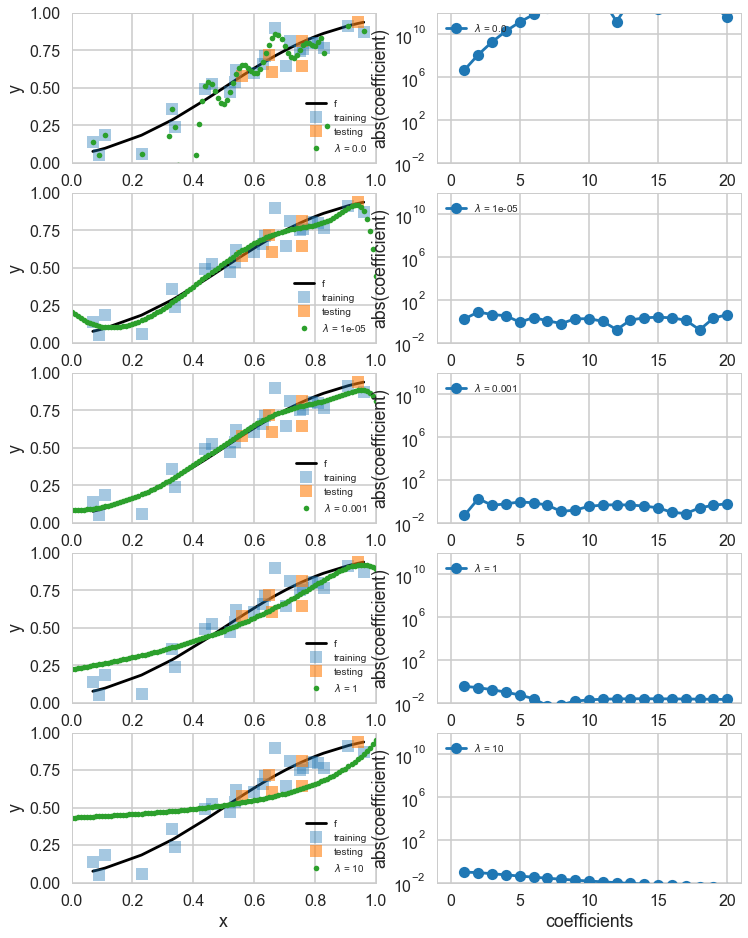

In [4]:
from sklearn.linear_model import Ridge

d=20

degrees=range(d+1)
traintestlists=make_features(xtrain, xtest, degrees)

fig, rows = plt.subplots(5, 2, figsize=(12, 16))

alphas = [0.0, 1e-5, 1e-3, 1, 10]
Xtrain = traintestlists[d]['train']
Xtest = traintestlists[d]['test']
for i, alpha in enumerate(alphas):
    l,r=rows[i]
    est = Ridge(alpha=alpha)
    est.fit(Xtrain, ytrain)
    plot_functions(est, l, df, alpha, xtest, Xtest, xtrain, ytrain )
    plot_coefficients(est, r, alpha)

As you can see, as  $$\lambda ~:~0\rightarrow 10$$
$$overfitting\rightarrow doing~well\rightarrow \text{ develop its own pattern irrespective of data}$$
As $\lambda$ large,  the penalty term dominates the risk.

** use cross-validation find critical $\lambda^*$**

To do this we use the concept of a *meta-estimator* from scikit-learn. As the API paper puts it:

>In scikit-learn, model selection is supported in two distinct meta-estimators, GridSearchCV and RandomizedSearchCV. They take as input an estimator (basic or composite), whose hyper-parameters must be optimized, and a set of hyperparameter settings to search through.

  
The concept of a meta-estimator allows us to wrap, for example, cross-validation, or methods that build and combine simpler models or schemes. For example:

    clf = Ridge()
    parameters = {"alpha": [1e-8, 1e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 1e-2, 1e-1, 1.0]}
    gridclassifier=GridSearchCV(clf, param_grid=parameters, cv=4, scoring="mean_squared_error")
    
The `GridSearchCV` replaces the manual iteration over `KFolds` and the averaging we did previously -- it did it all for us! 

    It takes a parameter grid in the shape of a dictionary as input, and sets $\lambda$ to the appropriate parameter values one by one. It then trains the model -- CV fashion -- gets the error. Finally it compares the errors for the different $\lambda$'s, and picks the best choice model.

In [5]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge

def cv_ridge(X, y, n_folds=4):
    clf = Ridge()
    parameters = {"alpha": \
                  [1e-8, 1e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 1e-2, 1e-1, 1.0]}
    #the scoring parameter below is the default one in ridge, but you can use a different one
    #in the cross-validation phase if you want.
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds,\
                      scoring="neg_mean_squared_error")
    gs.fit(X, y)
    return gs

In [6]:
fitmodel = cv_ridge(Xtrain, ytrain, n_folds=4)

In [7]:
print("best estimator",fitmodel.best_estimator_ )
print("best params ",fitmodel.best_params_)
print("best score", fitmodel.best_score_)
pd.DataFrame(fitmodel.cv_results_)


best estimator Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
best params  {'alpha': 0.1}
best score -0.007223338145105018


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_alpha,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,split3_test_score,split3_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.000937,0.000296,-0.568339,-0.003152,1e-08,{'alpha': 1e-08},10,-0.052902,-0.004086,-0.011089,-0.002394,-2.201632,-0.002830,-0.007732,-0.003298,0.000385,0.000135,0.943150,0.000627
1,0.000706,0.000205,-0.030345,-0.003418,1e-06,{'alpha': 1e-06},7,-0.002874,-0.004466,-0.012128,-0.002560,-0.098888,-0.003224,-0.007491,-0.003421,0.000212,0.000035,0.039708,0.000684
2,0.000765,0.000230,-0.037483,-0.003535,1e-05,{'alpha': 1e-05},9,-0.005265,-0.004626,-0.012036,-0.002650,-0.124678,-0.003248,-0.007951,-0.003617,0.000243,0.000098,0.050400,0.000718
3,0.000718,0.000240,-0.031742,-0.003612,5e-05,{'alpha': 5e-05},8,-0.004476,-0.004698,-0.011087,-0.002815,-0.103640,-0.003256,-0.007764,-0.003678,0.000209,0.000093,0.041576,0.000697
4,0.000945,0.000303,-0.028982,-0.003654,0.0001,{'alpha': 0.0001},6,-0.004632,-0.004729,-0.010848,-0.002911,-0.093012,-0.003260,-0.007436,-0.003714,0.000341,0.000166,0.037033,0.000683
5,0.000643,0.000193,-0.022134,-0.003835,0.0005,{'alpha': 0.0005},5,-0.006157,-0.004861,-0.011056,-0.003118,-0.065406,-0.003285,-0.005918,-0.004074,0.000115,0.000022,0.025067,0.000694
6,0.000919,0.000273,-0.018920,-0.003983,0.001,{'alpha': 0.001},4,-0.006700,-0.004938,-0.011348,-0.003226,-0.052463,-0.003319,-0.005170,-0.004448,0.000217,0.000110,0.019499,0.000732
7,0.000637,0.000215,-0.009052,-0.004573,0.01,{'alpha': 0.01},2,-0.005138,-0.005320,-0.011771,-0.003551,-0.015724,-0.003794,-0.003575,-0.005627,0.000284,0.000103,0.004930,0.000911
8,0.001230,0.000442,-0.007223,-0.005751,0.1,{'alpha': 0.1},1,-0.002903,-0.006693,-0.013432,-0.004326,-0.009945,-0.004979,-0.002614,-0.007007,0.000167,0.000216,0.004633,0.001128
9,0.001242,0.000500,-0.016153,-0.013209,1,{'alpha': 1.0},3,-0.004912,-0.014526,-0.025135,-0.011092,-0.019074,-0.012390,-0.015492,-0.014830,0.000248,0.000197,0.007349,0.001542


In [8]:
alphawechoose = fitmodel.best_params_['alpha']
clf = Ridge(alpha=alphawechoose).fit(Xtrain,ytrain)

In [9]:
def plot_functions_onall(est, ax, df, alpha, xtrain, ytrain, Xtrain, xtest, ytest):
    """Plot the approximation of ``est`` on axis ``ax``. """
    ax.plot(df.x, df.f, color='k', label='f')
    ax.plot(xtrain, ytrain, 's', alpha=0.4, label="train")
    ax.plot(xtest, ytest, 's', alpha=0.6, label="test")
    transx=np.arange(0,1.1,0.01)
    transX = PolynomialFeatures(20).fit_transform(transx.reshape(-1,1))
    ax.plot(transx, est.predict(transX), '.', alpha=0.6, label="alpha = %s" % str(alpha))
    #print est.predict(transX)
    ax.set_ylim((0, 1))
    ax.set_xlim((0, 1))
    ax.set_ylabel('y')
    ax.set_xlabel('x')
    ax.legend(loc='lower right')

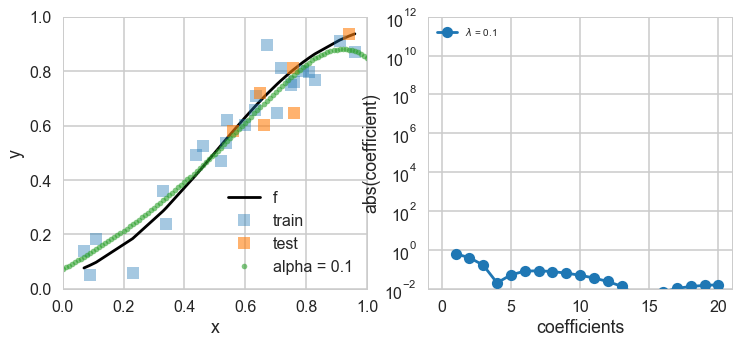

In [10]:
fig, rows = plt.subplots(1, 2, figsize=(12, 5))
l,r=rows
plot_functions_onall(clf, l, df, alphawechoose, xtrain, ytrain, Xtrain, xtest, ytest)
plot_coefficients(clf, r, alphawechoose)

As we can see, the best fit model is now chosen from the entire set of 20th order polynomials, and a non-zero hyperparameter α that we fit for ensures that only smooth models amonst these polynomials are chosen, by setting most of the polynomial coefficients to something close to 0 (Lasso sets them exactly to 0).

In [11]:
coef = clf.coef_.ravel()
coef

array([ 0.        ,  0.6180858 ,  0.39369391,  0.16141462,  0.01969653,
       -0.05117526, -0.0789494 , -0.08309389, -0.07542628, -0.06271175,
       -0.04866381, -0.03521299, -0.02326753, -0.01316185, -0.00491916,
        0.00159557,  0.00658756,  0.01028272,  0.01290103,  0.01464322,
        0.01568536])